In [1]:
import numpy as np
import sympy as sp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation 
import matplotlib.pyplot as plt 
from scipy.integrate import odeint,ode
from scipy.optimize import fsolve

Text(0, 0.5, 'position')

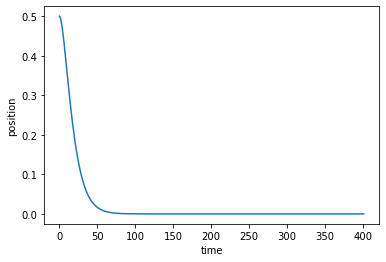

In [2]:
 class spring_mass:
        def __init__(self):
            self.m = 1
            self.c = 2
            self.k = 10
            self.kp = 100
            self.kd = -self.c + 2*np.sqrt(self.m*(self.k + self.kp))
            self.q = 0.5
            self.qdot = 0
            self.qddot = 0
            self.tstart = 0
            self.tpassed = 4
            self.x0 = np.array([self.q,self.qdot])
            
        def rhs(self,t,x):
            q = x[0]
            qdot = x[1]
            qddot = -((self.k + self.kp)/self.m)*q - ((self.c + self.kd)/self.m)*qdot
            return np.array([qdot,qddot])
        
        def onestep(self,z):
            eq = ode(self.rhs)
            eq.set_initial_value(z,self.tstart)
            dt = 0.01
            self.Z = [z]
            while eq.successful() and eq.t < self.tpassed:
                self.z = eq.integrate(eq.t+dt)
                self.Z = np.append(self.Z,[self.z],axis = 0)

e1 = spring_mass()
e1.onestep(e1.x0)

plt.plot(e1.Z[:,0])
plt.xlabel('time')
plt.ylabel('position')


In [3]:
t1, t2, l, c1, c2, I1, I2, w1, w2, m1, m2 = sp.symbols('theta1,theta2,l,c1,c2,I1,I2, omega1, omega2, m1, m2')
w1dot, w2dot = sp.symbols('omegadot1, omegadot2')
qddot = sp.Matrix([w1dot,w2dot])

g = 9.81

q = sp.Matrix([t1,t2])
qdot = sp.Matrix([w1,w2])

def i_1Ti(t,x,y):
    return sp.Matrix([[sp.cos(t), -sp.sin(t), x],
                     [sp.sin(t), sp.cos(t),   y],
                     [0,        0,            1]])

T1 = i_1Ti((3*sp.pi/2)+t1,0,0)
T2 = i_1Ti(t2,l,0)

# Position of COM in base frame:

X1 = T1@sp.Matrix([c1,0,1])
X2 = T1@T2@sp.Matrix([c2,0,1])

X1 = sp.Matrix(X1[0:2])

X2 = sp.Matrix(X2[0:2])

print(f"X1:\n{X1}\n")
print(f"X2:\n{X2}\n")

Vg1 = X1.jacobian(q)@sp.Matrix(qdot)
Vg2 = X2.jacobian(q)@sp.Matrix(qdot)

print(f"Vg1:\n{Vg1}\n")

print(f"Vg2:\n{Vg2}\n")

"""Calculating Kinetic Energy"""
T = (0.5 *m1 * ( Vg1.T @ Vg1))[0] + (0.5 *m2 * ( Vg2.T @ Vg2) )[0] + 0.5*I1*w1**2 + 0.5*I2*(w1+w2)**2

""" Calculating Potencial Energy"""
V = m1*g*X1[1] + m2*g*X2[1]

"""Calculating Lagrangian"""
L = T - V

""" Calculating equation of Dynamics for double pendulum"""
dLdq = sp.diff(L,q)
dLdqdot = sp.diff(L,qdot)
ddt_dLdqdot = sp.Matrix([sp.diff(dLdqdot[0],qdot).T,
                 sp.diff(dLdqdot[1],qdot).T])@qddot + sp.Matrix([sp.diff(dLdqdot[0],q).T,
                 sp.diff(dLdqdot[1],q).T])@qdot

print(f"Shape of ddt_dLdqdot: \n{ddt_dLdqdot.shape}\n")

eom = ddt_dLdqdot - dLdq
B = eom.subs({w1dot:0,w2dot:0})

"""Calculating Mass, gravity and coriolis matrix"""
M = eom.jacobian(qddot)

print(f"Shape of Mass matrix: \n{M.shape}\n")
G = B.subs({w1:0,w2:0})

print(f"Shape of Gravity matrix: \n{G.shape}\n")
C = B - G

print(f"Shape of Coriolis matrix: \n{C.shape}\n")

X1:
Matrix([[c1*sin(theta1)], [-c1*cos(theta1)]])

X2:
Matrix([[c2*(sin(theta1)*cos(theta2) + sin(theta2)*cos(theta1)) + l*sin(theta1)], [c2*(sin(theta1)*sin(theta2) - cos(theta1)*cos(theta2)) - l*cos(theta1)]])

Vg1:
Matrix([[c1*omega1*cos(theta1)], [c1*omega1*sin(theta1)]])

Vg2:
Matrix([[c2*omega2*(-sin(theta1)*sin(theta2) + cos(theta1)*cos(theta2)) + omega1*(c2*(-sin(theta1)*sin(theta2) + cos(theta1)*cos(theta2)) + l*cos(theta1))], [c2*omega2*(sin(theta1)*cos(theta2) + sin(theta2)*cos(theta1)) + omega1*(c2*(sin(theta1)*cos(theta2) + sin(theta2)*cos(theta1)) + l*sin(theta1))]])

Shape of ddt_dLdqdot: 
(2, 1)

Shape of Mass matrix: 
(2, 2)

Shape of Gravity matrix: 
(2, 1)

Shape of Coriolis matrix: 
(2, 1)



In [17]:
class double_pendulum1():
    def __init__(self,m1= 1,m2 = 1, I1 = 0.1, I2 = 0.1, c1 = 0.5, c2 = 0.5, l = 1):
        self.m1 = m1
        self.m2 = m2
        self.I1 = I1
        self.I2 = I2
        self.c1 = c1
        self.c2 = c2
        self.l = l
        self.z_desired = np.array([0,1.53])
        self.z = np.array([1.53,0,0,0]) ## [theta1,theta2,omega1,omega2]
        self.kp = np.array([[100,0],
                            [0,100]])
        self.kd = 2*np.sqrt(self.kp)
#         print(self.kd)
        self.T = np.array([[0, 0]]).T
        self.Z = np.array([self.z])
        self.t_end = 3

    def set_equations(self,M,C,G):
        
        M = M.subs({l:self.l, c1:self.c1, c2:self.c2, I1:self.I1, I2:self.I2, m1:self.m1, m2:self.m2})
        C = C.subs({l:self.l, c1:self.c1, c2:self.c2, I1:self.I1, I2:self.I2, m1:self.m1, m2:self.m2})
        G = G.subs({l:self.l, c1:self.c1, c2:self.c2, I1:self.I1, I2:self.I2, m1:self.m1, m2:self.m2})

        
        self.M = sp.lambdify([t1, t2],M)
        self.C = sp.lambdify([t1, t2, w1, w2],C)
        self.G = sp.lambdify([t1, t2],G)
    
    def get_T(self,z):
        ''' Calculating Torque
            M(-kp(theta - theta_desired) - kd*thetadot) +C + G
            Here M,C,G are estimates.
        '''
        Torque = self.M(z[0],z[1])@np.array([-self.kp@(z[0:2]-self.z_desired[0:2]) -self.kd@(self.z[2:4])]).T + self.C(z[0],z[1],z[2],z[3]) + self.G(z[0],z[1])
#         print((z))
        return Torque 

    def rhs(self,t,z):
        '''
        Finding zdot numerically

        wdot =  M_inv * (T - C - G)
        '''
#         print(t)
        wdot = np.linalg.inv(self.M(z[0],z[1]))@(self.get_T(z) - self.C(z[0],z[1],z[2],z[3]) - self.G(z[0],z[1]))
        return np.array([z[2],z[3],wdot[0][0],wdot[1][0]],dtype=object)

        
    def solve_ode(self):
        eqn = ode(self.rhs)
        eqn.set_initial_value(self.z,0)
        dt = 0.01

        while eqn.successful() and (eqn.t < self.t_end):
            self.z = eqn.integrate(eqn.t+dt)
            self.Z = np.append(self.Z,[self.z],axis=0)

p1 = double_pendulum1()

p1.set_equations(M,C,G)

p1.solve_ode()


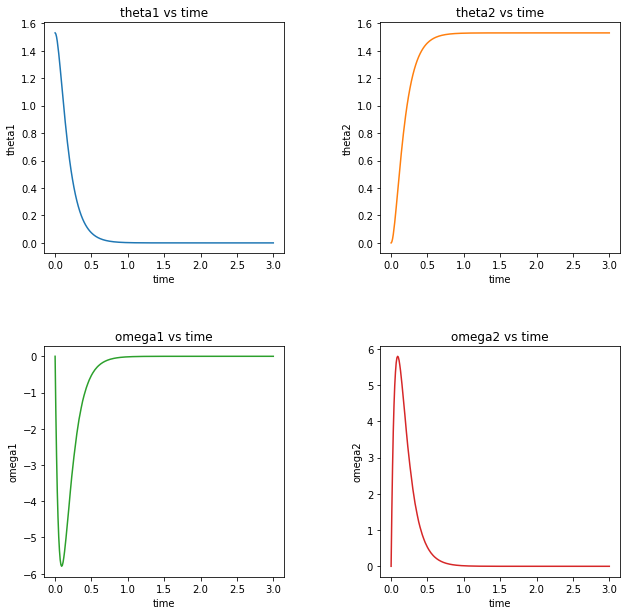

In [18]:
t = np.linspace(0,p1.t_end,len(p1.Z[:,0]))

fig, axs = plt.subplots(2, 2,figsize=(10,7))
axs[0, 0].plot(t,p1.Z[:,0])
axs[0, 0].set_title('theta1 vs time')
axs[0, 0].set(xlabel='time', ylabel='theta1')

axs[0, 1].plot(t,p1.Z[:,1], 'tab:orange')
axs[0, 1].set_title('theta2 vs time')
axs[0, 1].set(xlabel='time', ylabel='theta2')

axs[1, 0].plot(t,p1.Z[:,2], 'tab:green')
axs[1, 0].set_title('omega1 vs time')
axs[1, 0].set(xlabel='time', ylabel='omega1')

axs[1, 1].plot(t,p1.Z[:,3], 'tab:red')
axs[1, 1].set_title('omega2 vs time')
axs[1, 1].set(xlabel='time', ylabel='omega2')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [163]:
class save_animation(double_pendulum1):
    def __init__(self,x,y):
        super().__init__()
        self.X = x
        self.Y = y
        self.fig = plt.figure() 
        self.axis = plt.axes(autoscale_on=False,xlim = (-2.5, 2.5),
                            ylim = (-2.5, 2.5)) 
        self.axis.grid()
        self.axis.set_aspect('equal', adjustable='box')
        self.point1, = self.axis.plot(0,0, marker='o') 
        self.trace, = self.axis.plot([],[], lw= 1, ls='-') 
        self.line1, = self.axis.plot([],[], lw = 2)
        
    
    def init(self): 
        self.point1.set_data([],[]) 
        self.line1.set_data([],[])
        self.trace.set_data([],[])
        return self.point1, self.line1, self.trace,

    def end_eff(self,i):
        P = np.array([self.l*np.sin(self.X[i]), -self.l*np.cos(self.X[i])])
        Q = P + np.array([self.l*np.sin(self.X[i]+self.Y[i]), -self.l*np.cos(self.X[i]+self.Y[i])])
        return P,Q

    def init_q_his(self):
        P,Q = self.end_eff(0)
        self.q_history = np.array([Q])

    def animate(self,i):

        self.point1.set_data(0,0) 

        P,Q = self.end_eff(i)
        self.q_history = np.append(self.q_history,[Q],axis=0)

        self.line1.set_data([0,P[0],Q[0]],[0,P[1],Q[1]])

        self.trace.set_data(self.q_history[:i,0],self.q_history[:i,1]) 
        return self.point1, self.line1, self.trace,

    def save(self,file_name = 'results/double_pendulum_reachpoint.mp4'):
        anim = animation.FuncAnimation(self.fig, self.animate, init_func = self.init, 
                               frames = len(self.X), interval = 10, blit = True) 
        anim.save(file_name, writer = 'ffmpeg', fps = 100
                  )
        
print("Animation class")

Animation class


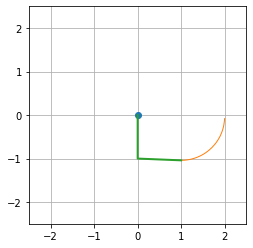

In [164]:
s1 = save_animation(p1.Z[:,0],p1.Z[:,1])
s1.init_q_his()
s1.save()

In [21]:
t0,tf = sp.symbols("t0,tf")

A = sp.Matrix([[1,t0,t0**2,t0**3,t0**4,t0**5],
               [1,tf,tf**2,tf**3,tf**4,tf**5],
               [0,1, 2*t0, 3*t0**2, 4*t0**3, 5*t0**4],
               [0,1, 2*tf, 3*tf**2, 4*tf**3, 5*tf**4],
               [0,0, 2, 6*t0, 12*t0**2, 20*t0**3],
               [0,0, 2, 6*tf, 12*tf**2, 20*tf**3]])

Tau = np.array([0,2*np.pi,0,0,0,0])

A_num = sp.lambdify([t0,tf],A)

B_num = np.linalg.inv(A_num(0,4))@Tau

B_num

array([ 0.        ,  0.        ,  0.        ,  0.9817477 , -0.36815539,
        0.03681554])

In [219]:
class draw_geometry():
    def __init__(self):
        self.a = 0.5
        self.b = 1
        self.x0 =  0.8
        self.y0 =  -0.75
        self.data = np.array([[self.x0, self.y0 + 0.5]])
        
        
    def get_eqn(self,B_num,t):

        tau = B_num@np.array([1,t,t**2,t**3,t**4,t**5]).T
        taudot = B_num@np.array([0,1,2*t,3*t**2,4*t**3,5*t**4]).T
        tauddot = B_num@np.array([0,0,2,6*t,12*t**2,20*t**3]).T
        
        x = self.x0 + 0.5*np.sin(tau)
        y = self.y0 + 0.5*np.cos(tau)
        
        self.data = np.concatenate((self.data,np.array([[x,y]])),axis=0)
        
        
        xdot = 0.5*np.cos(tau)*taudot
        ydot = -0.5*np.sin(tau)*taudot
        
        xddot = -0.5*np.sin(tau)*taudot + 0.5*np.cos(tau)*tauddot
        yddot = -0.5*np.cos(tau)*taudot - 0.5*np.sin(tau)*tauddot
        
        return x,y,xdot,ydot,xddot,yddot
    
    def set_eqn(self):
        X_eeff = sp.Matrix((T1@T2@sp.Matrix([l,0,1]))[:2])
        self.X_eeff_num = sp.lambdify([l,t1,t2],X_eeff)
        
        jac = X_eeff.jacobian(q)
        self.jac_num = sp.lambdify([l,t1,t2],jac)
        
        jacdot = sp.Matrix([sp.Matrix(sp.Matrix([jac[0,:]]).jacobian([t1])*w1 + sp.Matrix([jac[0,:]]).jacobian([t2])*w2).T,
                 sp.Matrix(sp.Matrix([jac[1,:]]).jacobian([t1])*w1 + sp.Matrix([jac[1,:]]).jacobian([t2])*w2).T])
        self.jacdot_num = sp.lambdify([l,t1,t2,w1,w2],jacdot)
        
        
    def fun(self,q,x_ref):
#         x_ref = np.array([[1,1]])
        
        return np.ndarray.flatten(self.X_eeff_num(1,q[0],q[1]) - np.array([x_ref]).T)
    
    def inverse_kin(self,t):
            x,y,xdot,ydot,xddot,yddot = self.get_eqn(B_num,t)
            t_ref = fsolve(self.fun,[1,1],args=(np.array([x,y])))
            
            tdot_ref = np.linalg.inv(self.jac_num(1,t_ref[0],t_ref[1]))@np.array([xdot,ydot]).T
            tddot_ref = np.linalg.inv(self.jac_num(1,t_ref[0],t_ref[1])) @ (np.array([xddot,yddot]).T - self.jacdot_num(1,t_ref[0],t_ref[1],tdot_ref[0],tdot_ref[1])@tdot_ref)
    
            return t_ref,tdot_ref,tddot_ref

class double_pendulum(draw_geometry):
    def __init__(self,m1= 1,m2 = 1, I1 = 0.1, I2 = 0.1, c1 = 0.5, c2 = 0.5, l = 1):
        super().__init__()
        self.m1 = m1
        self.m2 = m2
        self.I1 = I1
        self.I2 = I2
        self.c1 = c1
        self.c2 = c2
        self.l = l
        self.z = np.array([0.383,2.373,0,0]) ## [theta1,theta2,omega1,omega2]
        self.kp = np.array([[100,0],
                            [0,100]])
        self.kd = 2*np.sqrt(self.kp)
        self.T = np.array([[0, 0]]).T
        self.Z = np.array([self.z])
        self.set_eqn()
        self.Z_ref = np.array([self.inverse_kin(0)])
        self.t_end = 4 

    def set_equations(self,M,C,G):
        
        M = M.subs({l:self.l, c1:self.c1, c2:self.c2, I1:self.I1, I2:self.I2, m1:self.m1, m2:self.m2})
        C = C.subs({l:self.l, c1:self.c1, c2:self.c2, I1:self.I1, I2:self.I2, m1:self.m1, m2:self.m2})
        G = G.subs({l:self.l, c1:self.c1, c2:self.c2, I1:self.I1, I2:self.I2, m1:self.m1, m2:self.m2})

        
        self.M = sp.lambdify([t1, t2],M)
        self.C = sp.lambdify([t1, t2, w1, w2],C)
        self.G = sp.lambdify([t1, t2],G)
    
    def get_T(self,t,z):
        ''' Calculating Torque
            M(-kp(theta - theta_desired) - kd*thetadot) + C + G
            Here M,C,G are estimates.
        '''
        self.t_ref,self.tdot_ref,self.tddot_ref = self.inverse_kin(t)
        Torque = self.M(z[0],z[1])@np.array([self.tddot_ref -self.kp@(z[0:2]-self.t_ref) -self.kd@(self.z[2:4] - self.tdot_ref)]).T + self.C(z[0],z[1],z[2],z[3])@np.array([self.z[2:4]]) + self.G(z[0],z[1])

        return Torque 
        
        
    def rhs(self,t,z):
        '''
        Finding zdot numerically

        wdot =  M_inv * (T - C - G)
        '''
        
        wdot = np.linalg.inv(self.M(z[0],z[1]))@(self.get_T(t,z) - self.C(z[0],z[1],z[2],z[3]) - self.G(z[0],z[1]))
        
#         print(t)
        return np.array([z[2],z[3],wdot[0][0],wdot[1][0]],dtype=object)

        
    def solve_ode(self,z):
        eqn = ode(self.rhs)
        eqn.set_initial_value(z,0)
        dt = 0.01
        self.set_eqn()
        while eqn.successful() and (eqn.t < self.t_end):
            self.z = eqn.integrate(eqn.t+dt)
            self.Z = np.append(self.Z,[self.z],axis=0)
            self.Z_ref = np.concatenate((self.Z_ref,np.array([[self.t_ref,self.tdot_ref,self.tddot_ref]])),axis=0)

inst = double_pendulum()
inst.set_equations(M,C,G)
for i in range(1):
    inst.solve_ode(inst.Z[-1])
print(np.shape(inst.Z[:,0]))


(402,)


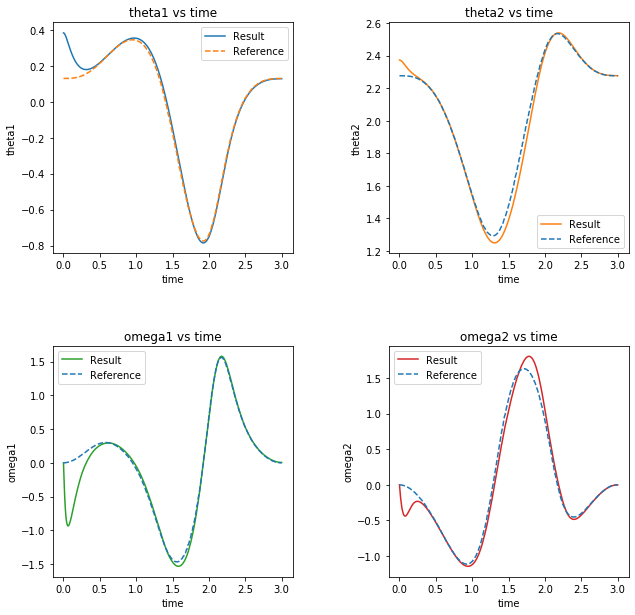

In [220]:
t = np.linspace(0,p1.t_end,len(inst.Z[:,0]))
fig, axs = plt.subplots(2, 2,figsize=(10,7))
axs[0, 0].plot(t,inst.Z[:,0],label='Result')
axs[0, 0].plot(t,inst.Z_ref[:,0,0],'--',label='Reference')
axs[0, 0].legend()
axs[0, 0].set_title('theta1 vs time')
axs[0, 0].set(xlabel='time', ylabel='theta1')

axs[0, 1].plot(t,inst.Z[:,1], 'tab:orange',label='Result')
axs[0, 1].plot(t,inst.Z_ref[:,0,1],'--',label='Reference')
axs[0, 1].legend()
axs[0, 1].set_title('theta2 vs time')
axs[0, 1].set(xlabel='time', ylabel='theta2')

axs[1, 0].plot(t,inst.Z[:,2], 'tab:green',label='Result')
axs[1, 0].plot(t,inst.Z_ref[:,1,0],'--',label='Reference')
axs[1, 0].legend()
axs[1, 0].set_title('omega1 vs time')
axs[1, 0].set(xlabel='time', ylabel='omega1')

axs[1, 1].plot(t,inst.Z[:,3], 'tab:red',label='Result')
axs[1, 1].plot(t,inst.Z_ref[:,1,1],'--',label='Reference')
axs[1, 1].legend()
axs[1, 1].set_title('omega2 vs time')
axs[1, 1].set(xlabel='time', ylabel='omega2')


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2,  
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

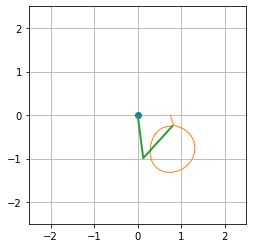

In [221]:
s1 = save_animation(inst.Z[:,0],inst.Z[:,1])
s1.init_q_his()
s1.save('results/double_pendulum_drawcircle.mp4')